In [1]:
import numpy as np
import random
from itertools import permutations
from itertools import product

from cvxopt import matrix, solvers
import math
import matplotlib.pyplot as plt
solvers.options['show_progress'] = False

In [2]:
class soccer_field:
    def __init__(self,positions):
        self.soccer_grid = np.zeros((2,4))
        self.initial_pos = positions
        self.done = False
        if positions[0,1] == 1:
            self.A_has_ball = True
            self.B_has_ball = False
        else:
            self.B_has_ball = True
            self.A_has_ball = False
        
        for i in range(len(positions)):
            if positions[i,0] < 4:
                self.soccer_grid[0,positions[i,0]] = i+1
                col = positions[i,0]
                row = 0
            else:
                self.soccer_grid[1,positions[i,0]-4] = i+1
                col = positions[i,0]-4
                row = 1
                
            if i == 0:
                self.pos_A = [row,col]
            else:
                self.pos_B = [row,col]
        
        self.reward = [0,0]
        
    def print_sg(self,verbose):
        if verbose:
            print(self.soccer_grid)
    
    def initial_state(self):
        if self.A_has_ball:
            init_pos = [[self.pos_A,self.pos_B],[1,0]]
        else:
            init_pos = [[self.pos_A,self.pos_B],[0,1]]
        return [init_pos]
        
    def index_error(self,r,c,action):
        if action == 1 and c+1<np.shape(self.soccer_grid)[1]:
            nex_pos = [r,c+1]
            move = True
        elif action == 2 and c-1>=0:
            move = True
            nex_pos = [r,c-1]
        elif action == 3 and r+1<np.shape(self.soccer_grid)[0]:
            move = True
            nex_pos = [r+1,c]
        elif action == 4 and r-1>=0:
            move = True
            nex_pos = [r-1,c]
        elif action == 0:
            move = True
            nex_pos = [r,c]
        else:
            move = False
            nex_pos = [r,c]
            
        return [move,nex_pos]
    
    def update_position(self,movements):
        for i in range(len(movements)):
            if movements[i,0] == 1:
                [r,c] = self.pos_A
                [move,[r1,c1]] = self.index_error(r,c,movements[i,1])
                    
                if move:
                    if self.soccer_grid[r1,c1] == 0:
                        self.pos_A = [r1,c1]
                        self.soccer_grid[r1,c1] = 1
                        self.soccer_grid[r,c] = 0
                    elif self.soccer_grid[r1,c1] != 0 and self.A_has_ball:
                        self.A_has_ball = False
                        self.B_has_ball = True
            else:
                [r,c] = self.pos_B
                [move,[r1,c1]] = self.index_error(r,c,movements[i,1])
                

                if move:
                    if self.soccer_grid[r1,c1] == 0:
                        self.pos_B  = [r1,c1]
                        self.soccer_grid[r1,c1] = 2
                        self.soccer_grid[r,c] = 0
                    elif self.soccer_grid[r1,c1] != 0 and self.B_has_ball:
                        self.B_has_ball = False     
                        self.A_has_ball = True
                        
        if self.A_has_ball:
            new_pos = [[self.pos_A,self.pos_B],[1,0]]
        else:
            new_pos = [[self.pos_A,self.pos_B],[0,1]]
        
        if (self.pos_A[1] == 0 and self.A_has_ball) or (self.pos_B[1] == 0 and self.B_has_ball):
            self.reward = [100,-100]
            self.done = True
        elif (self.pos_A[1] == 3 and self.A_has_ball) or (self.pos_B[1] == 3 and self.B_has_ball):
            self.reward = [-100,100]
            self.done = True
        return [self.reward,new_pos,self.done]
          

In [3]:
def explore_Greedy(epsilon,v):
    if np.random.rand()<epsilon:
        return np.random.randint(0,5)
    else:
        loc = np.where(v == np.max(v))[0]
        if len(loc)>1:
            select = random.randint(0,len(loc)-1)
            return np.where(v == np.max(v))[0][select]
        else:
            select = random.randint(0,len(loc)-1)
            return np.where(v == np.max(v))[0][select]

def CE(Q_A_state,Q_B_state,flag):
    obj = matrix(-np.add(Q_A_state , Q_B_state)) # maximize for both players
    
    eq_cm11=np.zeros(25)
    eq_cm11[0:5] = -Q_A_state[0:5]
    eq_cm11[5:10] =  Q_A_state[0:5]
    eq_cm12=np.zeros(25)
    eq_cm12[0:5] = -Q_A_state[0:5]
    eq_cm12[10:15] =  Q_A_state[0:5]
    eq_cm13=np.zeros(25)
    eq_cm13[0:5] = -Q_A_state[0:5]
    eq_cm13[15:20] =  Q_A_state[0:5]
    eq_cm14=np.zeros(25)
    eq_cm14[0:5] = -Q_A_state[0:5]
    eq_cm14[20:] =  Q_A_state[0:5]
    
    
    eq_cm21=np.zeros(25)
    eq_cm21[5:10] = -Q_A_state[5:10]
    eq_cm21[0:5] =  Q_A_state[5:10]
    eq_cm22=np.zeros(25)
    eq_cm22[5:10] = -Q_A_state[5:10]
    eq_cm22[10:15] =  Q_A_state[5:10]
    eq_cm23=np.zeros(25)
    eq_cm23[5:10] = -Q_A_state[5:10]
    eq_cm23[15:20] =  Q_A_state[5:10]
    eq_cm24=np.zeros(25)
    eq_cm24[5:10] = -Q_A_state[5:10]
    eq_cm24[20:] =  Q_A_state[5:10]
    
    eq_cm31=np.zeros(25)
    eq_cm31[10:15] = -Q_A_state[10:15]
    eq_cm31[0:5] =  Q_A_state[10:15]
    eq_cm32=np.zeros(25)
    eq_cm32[10:15] = -Q_A_state[10:15]
    eq_cm32[5:10] =  Q_A_state[10:15]
    eq_cm33=np.zeros(25)
    eq_cm33[10:15] = -Q_A_state[10:15]
    eq_cm33[15:20] =  Q_A_state[10:15]
    eq_cm34=np.zeros(25)
    eq_cm34[10:15] = -Q_A_state[10:15]
    eq_cm34[20:] =  Q_A_state[10:15]
    
    eq_cm41=np.zeros(25)
    eq_cm41[15:20] = -Q_A_state[15:20]
    eq_cm41[0:5] =  Q_A_state[15:20]
    eq_cm42=np.zeros(25)
    eq_cm42[15:20] = -Q_A_state[15:20]
    eq_cm42[5:10] =  Q_A_state[15:20]
    eq_cm43=np.zeros(25)
    eq_cm43[15:20] = -Q_A_state[15:20]
    eq_cm43[10:15] =  Q_A_state[15:20]
    eq_cm44=np.zeros(25)
    eq_cm44[15:20] = -Q_A_state[15:20]
    eq_cm44[20:] =  Q_A_state[15:20]
    
    eq_cm51=np.zeros(25)
    eq_cm51[20:] = -Q_A_state[20:]
    eq_cm51[0:5] =  Q_A_state[20:]
    eq_cm52=np.zeros(25)
    eq_cm52[20:] = -Q_A_state[20:]
    eq_cm52[5:10] =  Q_A_state[20:]
    eq_cm53=np.zeros(25)
    eq_cm53[20:] = -Q_A_state[20:]
    eq_cm53[10:15] =  Q_A_state[20:]
    eq_cm54=np.zeros(25)
    eq_cm54[20:] = -Q_A_state[20:]
    eq_cm54[15:20] =  Q_A_state[20:]
    
    
    eq_cmB11=np.zeros(25)
    eq_cmB11[[0,5,10,15,20]] = -Q_B_state[[0,5,10,15,20]]
    eq_cmB11[[1,6,11,16,21]] =  Q_B_state[[0,5,10,15,20]]
    eq_cmB12=np.zeros(25)
    eq_cmB12[[0,5,10,15,20]] = -Q_B_state[[0,5,10,15,20]]
    eq_cmB12[[2,7,12,17,22]] =  Q_B_state[[0,5,10,15,20]]
    eq_cmB13=np.zeros(25)
    eq_cmB13[[0,5,10,15,20]] = -Q_B_state[[0,5,10,15,20]]
    eq_cmB13[[3,8,13,18,23]] =  Q_B_state[[0,5,10,15,20]]
    eq_cmB14=np.zeros(25)
    eq_cmB14[[0,5,10,15,20]] = -Q_B_state[[0,5,10,15,20]]
    eq_cmB14[[4,9,14,19,24]] =  Q_B_state[[0,5,10,15,20]]
    
    eq_cmB21=np.zeros(25)
    eq_cmB21[[0,5,10,15,20]] =  Q_B_state[[1,6,11,16,21]]
    eq_cmB21[[1,6,11,16,21]] = -Q_B_state[[1,6,11,16,21]]
    eq_cmB22=np.zeros(25)
    eq_cmB22[[1,6,11,16,21]] = -Q_B_state[[1,6,11,16,21]]
    eq_cmB22[[2,7,12,17,22]] =  Q_B_state[[1,6,11,16,21]]
    eq_cmB23=np.zeros(25)
    eq_cmB23[[1,6,11,16,21]] = -Q_B_state[[1,6,11,16,21]]
    eq_cmB23[[3,8,13,18,23]] =  Q_B_state[[1,6,11,16,21]]
    eq_cmB24=np.zeros(25)
    eq_cmB24[[1,6,11,16,21]] = -Q_B_state[[1,6,11,16,21]]
    eq_cmB24[[4,9,14,19,24]] =  Q_B_state[[1,6,11,16,21]]
    
    eq_cmB31=np.zeros(25)
    eq_cmB31[[2,7,12,17,22]] = -Q_B_state[[2,7,12,17,22]]
    eq_cmB31[[1,6,11,16,21]] =  Q_B_state[[2,7,12,17,22]]
    eq_cmB32=np.zeros(25)
    eq_cmB32[[0,5,10,15,20]] = Q_B_state[[2,7,12,17,22]]
    eq_cmB32[[2,7,12,17,22]] = -Q_B_state[[2,7,12,17,22]]
    eq_cmB33=np.zeros(25)
    eq_cmB33[[2,7,12,17,22]] = -Q_B_state[[2,7,12,17,22]]
    eq_cmB33[[3,8,13,18,23]] =  Q_B_state[[2,7,12,17,22]]
    eq_cmB34=np.zeros(25)
    eq_cmB34[[2,7,12,17,22]] = -Q_B_state[[2,7,12,17,22]]
    eq_cmB34[[4,9,14,19,24]] =  Q_B_state[[2,7,12,17,22]]
    
    eq_cmB41=np.zeros(25)
    eq_cmB41[[3,8,13,18,23]] = -Q_B_state[[3,8,13,18,23]]
    eq_cmB41[[1,6,11,16,21]] =  Q_B_state[[3,8,13,18,23]]
    eq_cmB42=np.zeros(25)
    eq_cmB42[[3,8,13,18,23]] = -Q_B_state[[3,8,13,18,23]]
    eq_cmB42[[2,7,12,17,22]] =  Q_B_state[[3,8,13,18,23]]
    eq_cmB43=np.zeros(25)
    eq_cmB43[[0,5,10,15,20]] =  Q_B_state[[3,8,13,18,23]]
    eq_cmB43[[3,8,13,18,23]] = -Q_B_state[[3,8,13,18,23]]
    eq_cmB44=np.zeros(25)
    eq_cmB44[[3,8,13,18,23]] = -Q_B_state[[3,8,13,18,23]]
    eq_cmB44[[4,9,14,19,24]] =  Q_B_state[[3,8,13,18,23]]
    
    eq_cmB51=np.zeros(25)
    eq_cmB51[[4,9,14,19,24]] = -Q_B_state[[4,9,14,19,24]]
    eq_cmB51[[1,6,11,16,21]] =  Q_B_state[[4,9,14,19,24]]
    eq_cmB52=np.zeros(25)
    eq_cmB52[[4,9,14,19,24]] = -Q_B_state[[4,9,14,19,24]]
    eq_cmB52[[2,7,12,17,22]] =  Q_B_state[[4,9,14,19,24]]
    eq_cmB53=np.zeros(25)
    eq_cmB53[[4,9,14,19,24]] = -Q_B_state[[4,9,14,19,24]]
    eq_cmB53[[3,8,13,18,23]] =  Q_B_state[[4,9,14,19,24]]
    eq_cmB54=np.zeros(25)
    eq_cmB54[[0,5,10,15,20]] =  Q_B_state[[4,9,14,19,24]]
    eq_cmB54[[4,9,14,19,24]] = -Q_B_state[[4,9,14,19,24]]
    
    
    
    
    
    eq_00 = np.zeros(25)
    eq_00[0] = -1
    eq_01 = np.zeros(25)
    eq_01[1] = -1
    eq_02 = np.zeros(25)
    eq_02[2] = -1
    eq_03 = np.zeros(25)
    eq_03[3] = -1
    eq_04 = np.zeros(25)
    eq_04[4] = -1
    eq_05 = np.zeros(25)
    eq_05[5] = -1
    eq_06 = np.zeros(25)
    eq_06[6] = -1
    eq_07 = np.zeros(25)
    eq_07[7] = -1
    eq_08 = np.zeros(25)
    eq_08[8] = -1
    eq_09 = np.zeros(25)
    eq_09[9] = -1
    eq_10 = np.zeros(25)
    eq_10[10] = -1
    eq_11 = np.zeros(25)
    eq_11[11] = -1
    eq_12 = np.zeros(25)
    eq_12[12] = -1
    eq_13 = np.zeros(25)
    eq_13[13] = -1
    eq_14 = np.zeros(25)
    eq_14[14] = -1
    eq_15 = np.zeros(25)
    eq_15[15] = -1
    eq_16 = np.zeros(25)
    eq_16[16] = -1
    eq_17 = np.zeros(25)
    eq_17[17] = -1
    eq_18 = np.zeros(25)
    eq_18[18] = -1
    eq_19 = np.zeros(25)
    eq_19[19] = -1
    eq_20 = np.zeros(25)
    eq_20[20] = -1
    eq_21 = np.zeros(25)
    eq_21[21] = -1
    eq_22 = np.zeros(25)
    eq_22[22] = -1
    eq_23 = np.zeros(25)
    eq_23[23] = -1
    eq_24 = np.zeros(25)
    eq_24[24] = -1
    
    eq_s0 = np.ones(25) 
    eq_s1 = -np.ones(25) 
    
    cons_m=[]
    for s in range(25):
        c_m = [eq_cm11[s],eq_cm12[s],eq_cm13[s],eq_cm14[s],eq_cm21[s],eq_cm22[s],eq_cm23[s],eq_cm24[s],
                  eq_cm31[s],eq_cm32[s],eq_cm33[s],eq_cm34[s],eq_cm41[s],eq_cm42[s],eq_cm43[s],eq_cm44[s],
                  eq_cm51[s],eq_cm52[s],eq_cm53[s],eq_cm54[s]]
        c_m +=[eq_cmB11[s],eq_cmB12[s],eq_cmB13[s],eq_cmB14[s],eq_cmB21[s],eq_cmB22[s],eq_cmB23[s],eq_cmB24[s],
                  eq_cmB31[s],eq_cmB32[s],eq_cmB33[s],eq_cmB34[s],eq_cmB41[s],eq_cmB42[s],eq_cmB43[s],eq_cmB44[s],
                  eq_cmB51[s],eq_cmB52[s],eq_cmB53[s],eq_cmB54[s]]
        
        c_m += [eq_00[s],eq_01[s],eq_02[s],eq_03[s],eq_04[s],eq_05[s],eq_06[s],eq_07[s],eq_08[s],eq_09[s],
                  eq_10[s],eq_11[s],eq_12[s],eq_13[s],eq_14[s],eq_15[s],eq_16[s],eq_17[s],eq_18[s],eq_19[s],
                  eq_20[s],eq_21[s],eq_22[s],eq_23[s],eq_24[s]]
        c_m += [eq_s0[s],eq_s1[s]]
        
        cons_m.append(c_m)
        
    
    A=matrix(cons_m)
    
    rs_m = np.zeros(67)
    rs_m[65] = 1
    rs_m[66] = -1
    b = matrix(rs_m)
    glpksolver = 'cvxopt_glpk'
    sol=solvers.lp(obj,A,b, solver=glpksolver)
    #print(sol['status'])
    result=sol['x']
    if flag==1:
        Q_s=Q_A_state
    else:
        Q_s=Q_B_state
    V=0
    for i in range(25):
        V += (Q_s[i] )*result[i]
    
    return V



In [4]:

max_alpha = 0.9
min_alpha = 0.001
max_eps = 1
min_eps = 0.001
LAMBDA = 0.001
LAMBDA_1 = 0.9

epsilon = max_eps
alpha = max_alpha
gamma = 0.9

r = []

k = []
for i in range(2):
    for j in range(4):
        k.append([i,j])


perm = permutations(k,2)

all_seq = []

ball = [[0,1],[1,0]]

count = 0
for i in list(perm):
    for j in range(2):
        all_seq.append([list(i),ball[j]])
        
z = product([0, 1, 2, 3, 4], repeat = 2)

action_list = []
for i in list(z):
    action_list.append(list(i))
    
Q_A = np.ones((112,25))
Q_B = np.ones((112,25))
step = 0 
done = False
s_a = []

iteration = 500
       

def alpha_reduce_2(step,iteration):
    if step <= 0.7*200000:
        m = (0.15-0.2)/(0.7*200000)
        return m*step+0.2
    else:
        m = (0.001-0.15)/(300000-0.7*300000)
        return m*(step-0.7*300000)+0.15

def alpha_reduce_3(step,limit,alpha_max):
    limit=1000000
    if step <= limit:
        m = (0.001-alpha_max)/(limit)
        return m*step+alpha_max
    else:
        return 0.001
    
    
def alpha_reduce(min_alpha,max_alpha,step):
    return min_alpha + (max_alpha - min_alpha) * math.exp(-LAMBDA_1*step)

all_action = []
#for i in range(iteration):
action = [[3, 3, 2]]
limit = 1000000
while step < limit:
    
    s_p = np.array([[2,0],[1,1]])
    soccer = soccer_field(s_p)
    [state_s] = soccer.initial_state()
    new_pos=state_s
    state = all_seq.index(state_s)
    init_state = all_seq.index(state_s)
    
    done = False
    samp = 1
    
    while not done:
        ###
        #action_A = explore_Greedy(epsilon,Q_A[state])
        #action_B = explore_Greedy(epsilon,Q_A[state])
        ###
        first = random.randint(1,2)
        prev = list(Q_A[init_state,])[20]
        action_A = np.random.randint(0,5)
        action_B = np.random.randint(0,5)
        #first = action[step][2]
        #action_A = action[step][0]
        #action_B = action[step][1]
        #all_action.append([action_A,action_B,first])
        
        if first == 1:
            move = np.array([[1,action_A],[2,action_B]])
        else:
            move = np.array([[2,action_B],[1,action_A]])
        
        [r,new_pos,done] = soccer.update_position(move) 
        state2 = all_seq.index(new_pos)
        V_A = CE(Q_A[state2,],Q_B[state2,],1)
        V_B = CE(Q_A[state2,],Q_B[state2,],2)
        a_use = action_list.index([action_A,action_B])
        
        if r[0] == 0 or r[1] == 0:
            Q_A[state,a_use] += alpha * ((1-gamma)*r[0] + gamma*V_A - Q_A[state,a_use])
            Q_B[state,a_use] += alpha * ((1-gamma)*r[1] + gamma*V_B - Q_B[state,a_use])
            new = list(Q_A[init_state,])[20]
            #if np.linalg.norm(np.array(prev)-np.array(new))>0:
            s_a.append([step,np.linalg.norm(np.array(prev)-np.array(new))])

            state = state2
        else:
            #game end
            Q_A[state,a_use] += alpha * ((1-gamma)*r[0] - Q_A[state,a_use])
            Q_B[state,a_use] += alpha * ((1-gamma)*r[1] - Q_B[state,a_use])     
            new = list(Q_A[init_state,])[20]
            s_a.append([step,np.linalg.norm(np.array(prev)-np.array(new))])
            #print(new)
            #st
            #if np.linalg.norm(np.array(prev)-np.array(new))>0:
            #s_a.append([step,np.max(np.abs((np.array(prev)-np.array(new))))])
                
        step += 1
            
        samp = 2
        #epsilon = eps_reduce_2(step,iteration)
        alpha = alpha_reduce_3(step,limit,max_alpha)
        #alpha = alpha_reduce(min_alpha,max_alpha,step)
        #alpha = alpha_reduce_2(step,iteration)
        ##
        #epsilon = alpha_reduce(min_eps,max_eps,step)
        ##
        #print(step)
s_a_use = np.reshape(s_a,[-1,2])

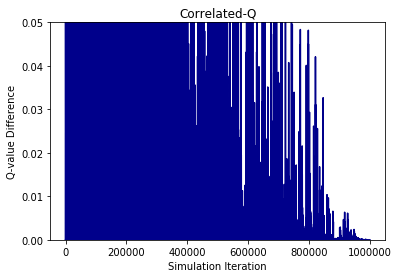

In [5]:
s = np.where(s_a_use[:,1]>0)
k = s_a_use[np.where(s_a_use[:,1]>=0),1][0]
plt.rcParams['agg.path.chunksize'] = 10000
#print(k[1000])
#print(s_a[850000:])
p = np.roll(k, 10000)
plt.plot(s_a_use[:,1],'-',color='darkblue')
plt.ylim([0,0.05])
#plt.xlim([0,10e5])
plt.xlabel('Simulation Iteration')
plt.ylabel('Q-value Difference')
plt.title('Correlated-Q')
plt.show()
#print(k)


In [6]:
print(init_state)

30


In [12]:
print(Q_A[30,])
print(Q_B[30,])
print(np.max(Q_A[init_state,]))
print(np.max(Q_B[init_state,]))

[ 0.04073222  0.038445   10.         -0.27927784  0.02698939 -10.
 -7.54715439 10.         -0.09967289 -0.01327101  0.04104822  0.04125423
 10.         -0.17785621  0.0259336   0.27645861 -1.50430632 10.
 -0.04763426 -0.30448961  0.05645717  0.05624877 10.         -0.28213061
  0.02769997]
[-0.02703764 -0.02482436 -10.          0.29106752 -0.01417146 10.
  7.54911714 -10.          0.10966763  0.02321272 -0.02740067 -0.02757102
 -10.          0.19244647 -0.01310859 -0.26233726  1.51601611 -10.
  0.0602295   0.31633022 -0.0419211  -0.04171731 -10.          0.29392286
 -0.0148783 ]
10.0
10.0


In [8]:
a=[1,2,3,4,5,6,7]
#b=np.zeros(10)
C=[0,1,2,3,4]
#b[[0,1,2,3,4]]=a[0:5]
a +=C
print(a)

[1, 2, 3, 4, 5, 6, 7, 0, 1, 2, 3, 4]


In [9]:
print(all_action)

[]


In [10]:
print(state)

31


In [11]:
print(prev)
print(new)

0.0564571683242
0.0564571683242
